# Modeling data with fico_features
- last_fico_range_high
- last_fico_range_low 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import os

import torch

import warnings
warnings.filterwarnings("ignore") 

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [ ]:
## Load before 2017 data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_train_before_2017_with_fico.csv"
data = pd.read_csv(data_path, low_memory=False)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

data = data.drop(columns=ambiguous_features)

In [4]:
data['loan_status'].value_counts()

loan_status
0    1207257
1     287765
Name: count, dtype: int64

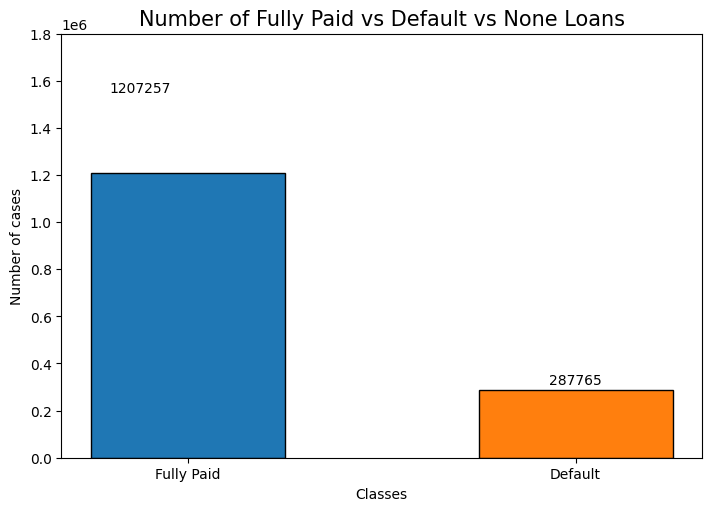

In [5]:
# Visualizing the encoded target

defalut_fully_paid = data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Number of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
#ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [6]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
print(f"Ratio of: (Fully Paid) / Default  : {defalut_fully_paid[0]/defalut_fully_paid[1]}")

Ratio of: (Fully Paid) / Default  : 4.195287821660035


In [7]:
print(f"The number of features : {len(data.columns)}\nThe target feature : {data[['loan_status']].columns}")

The number of features : 68
The target feature : Index(['loan_status'], dtype='object')


## Base Modeling

In [ ]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_test_after_2017_with_fico.csv"
test_data = pd.read_csv(test_data_path)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

test_data = test_data.drop(columns=ambiguous_features)

print(f"Test dataset the number of columns : {len(test_data.columns)}")

In [9]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1495022 entries, 0 to 1495021
Data columns (total 67 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   1495022 non-null  float64
 1   funded_amnt                 1495022 non-null  float64
 2   funded_amnt_inv             1495022 non-null  float64
 3   term                        1495022 non-null  object 
 4   int_rate                    1495022 non-null  float64
 5   installment                 1495022 non-null  float64
 6   grade                       1495022 non-null  object 
 7   sub_grade                   1495022 non-null  object 
 8   home_ownership              1495022 non-null  object 
 9   annual_inc                  1495022 non-null  float64
 10  verification_status         1495022 non-null  object 
 11  zip_code                    1495022 non-null  float64
 12  addr_state                  1495022 non-null  object 
 1

In [10]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

# 🔹 Test 데이터 Encoding 적용
X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

# ✅ Train에서 학습한 LabelEncoder로 변환 (fit_transform() ❌ → transform() ✅)
for col in X_test.select_dtypes(include=['object']).columns:
    if col in label_encoders:  # Train에서 학습한 LabelEncoder가 존재하는 경우
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# ✅ y_test도 Train에서 학습한 LabelEncoder 적용
y_test['loan_status'] = le_y.transform(y_test['loan_status'].astype(str))

# ✅ 변환된 데이터 확인
print("Encoded X_test sample:\n", X_test.head())
print("Encoded y_test sample:\n", y_test.head())

Encoded data_x sample:
    loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0    12000.0      12000.0          12000.0     0     10.99       392.81   
1     4800.0       4800.0           4800.0     0     10.99       157.13   
2    27050.0      27050.0          27050.0     0     10.99       885.46   
3    12000.0      12000.0          12000.0     0      7.62       373.94   
4    14000.0      14000.0          14000.0     0     12.85       470.71   

   grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
0      1          6               5     60000.0  ...           100.0   
1      1          6               1     39600.0  ...           100.0   
2      1          6               4     55000.0  ...           100.0   
3      0          2               1     96500.0  ...           100.0   
4      1          8               5     88000.0  ...            78.6   

   percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  \
0               0.0

In [11]:
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 1196017 samples (80.0%)
Validation size: 299005 samples (20.0%)
Test size: 266107 samples (17.8%)


In [12]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
1406896   0.230769     0.230769         0.235182   0.0  0.415660     0.202111   
1267104   0.128205     0.128205         0.133206   0.0  0.238411     0.112403   
661712    0.692308     0.692308         0.694073   0.0  0.035840     0.495621   
703097    0.846154     0.846154         0.847036   0.0  0.363459     0.681019   
1214333   0.064103     0.064103         0.069471   0.0  0.291001     0.065689   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
1406896  0.333333   0.411765             1.0    0.000482  ...             1.0   
1267104  0.166667   0.235294             1.0    0.000454  ...             1.0   
661712   0.000000   0.029412             0.2    0.000682  ...             1.0   
703097   0.333333   0.411765             0.2    0.001818  ...             1.0   
1214333  0.333333   0.294118             0.8    0.000582  ...             1.0   

   

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=300,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.49060	validation_1-logloss:0.49231
[1]	validation_0-logloss:0.48806	validation_1-logloss:0.49148
[2]	validation_0-logloss:0.48557	validation_1-logloss:0.49032
[3]	validation_0-logloss:0.48335	validation_1-logloss:0.49014
[4]	validation_0-logloss:0.48092	validation_1-logloss:0.48934
[5]	validation_0-logloss:0.47877	validation_1-logloss:0.48882
[6]	validation_0-logloss:0.47640	validation_1-logloss:0.48804
[7]	validation_0-logloss:0.47430	validation_1-logloss:0.48753
[8]	validation_0-logloss:0.47223	validation_1-logloss:0.48737
[9]	validation_0-logloss:0.46998	validation_1-logloss:0.48662
[10]	validation_0-logloss:0.46773	validation_1-logloss:0.48558
[11]	validation_0-logloss:0.46573	validation_1-logloss:0.48543
[12]	validation_0-logloss:0.46354	validation_1-logloss:0.48442
[13]	validation_0-logloss:0.46137	validation_1-logloss:0.48372
[14]	validation_0-logloss:0.45926	validation_1-logloss:0.48304
[15]	validation_0-logloss:0.45715	validation_1-logloss:0.48238
[1

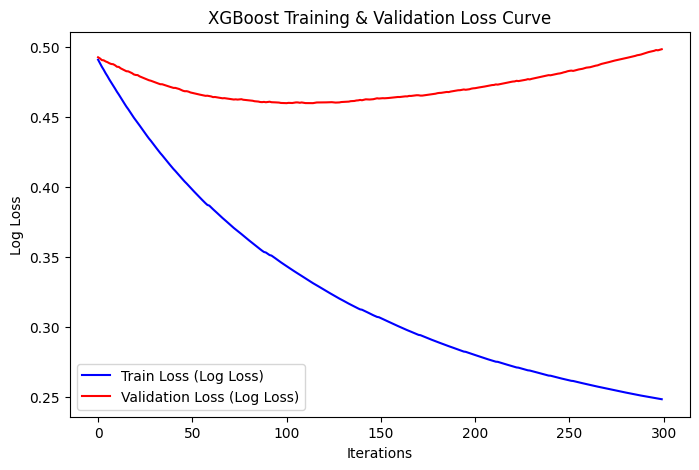

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    208044
           1       1.00      0.10      0.18     58063

    accuracy                           0.80    266107
   macro avg       0.90      0.55      0.53    266107
weighted avg       0.84      0.80      0.73    266107



In [14]:
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

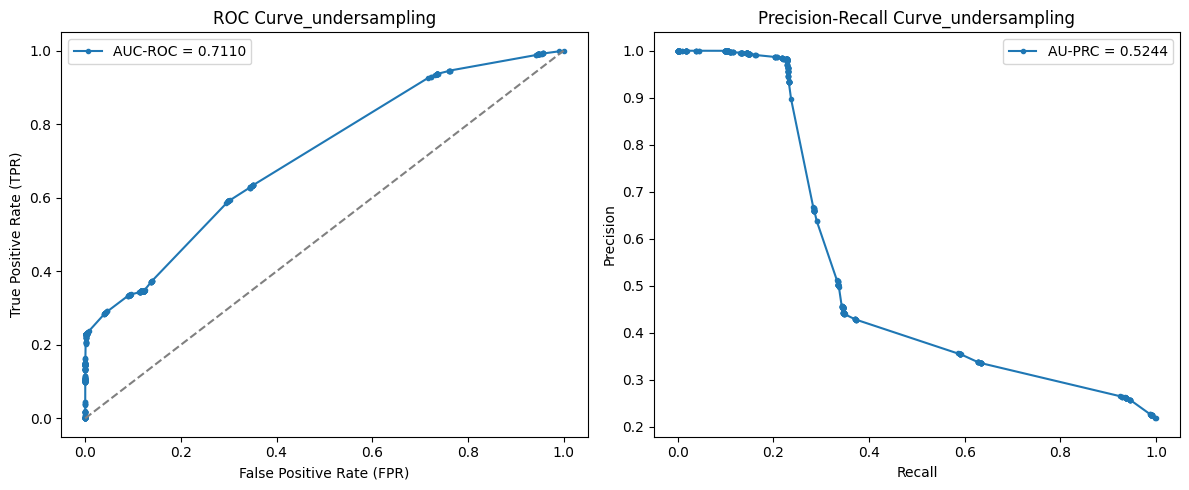

In [15]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

In [ ]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()

## Oversampling SMOTE-NC

In [ ]:
## Load before 2017 data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_train_before_2017_with_fico.csv"
data = pd.read_csv(data_path, low_memory=False)

In [19]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

In [ ]:
"""from imblearn.over_sampling import SMOTENC

categorical_features = data_x.select_dtypes(include=['object', 'category']).columns
categorical_feature_indices = [data_x.columns.get_loc(col) for col in categorical_features]

smotenc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(data_x, data_y)

print(f"SMOTE-MC data length : {len(X_train_smotenc)}")
print(f"SMOTE-MC data length : {len(y_train_smotenc)}")

print(f"\nThe number of Classes : {y_train_smotenc.value_counts()}")"""

SMOTE-MC data length : 2414514
SMOTE-MC data length : 2414514

The number of Classes : loan_status
0              1207257
1              1207257
Name: count, dtype: int64


In [ ]:
"""## 증강 시간이 오래 걸리기 때문 데이터 저장을 한다.
augmentation_data = pd.concat([X_train_smotenc, y_train_smotenc], axis = 1)

address = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"

augmentation_data.to_csv(path_or_buf=address+"smotenc_data_with_fico.csv", index=False)"""

In [24]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_test_after_2017_with_fico.csv"
test_data = pd.read_csv(test_data_path)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

test_data = test_data.drop(columns=ambiguous_features)

print(f"Test dataset the number of columns : {len(test_data.columns)}")

Test dataset the number of columns : 66


In [27]:
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/Datasetsmotenc_data_with_fico.csv"
augmentation_data = pd.read_csv(data_path)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

augmentation_data = augmentation_data.drop(columns=ambiguous_features)

print(f"Augmentation_data the number of columns : {len(augmentation_data.columns)}")

Augmentation_data the number of columns : 66


In [28]:
X_train_smotenc = augmentation_data.drop(columns='loan_status')
y_train_smotenc = augmentation_data[['loan_status']]

In [29]:
# 4️⃣ Label Encoding (Train 데이터)
label_encoders = {}

# 🔹 X_train_smotenc: 범주형(Object) 컬럼 Label Encoding
for col in X_train_smotenc.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train_smotenc[col] = le.fit_transform(X_train_smotenc[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 y_train_smotenc: loan_status도 Label Encoding
le_y = LabelEncoder()
y_train_smotenc['loan_status'] = le_y.fit_transform(y_train_smotenc['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded X_train_smotenc sample:\n", X_train_smotenc.head())
print("Encoded y_train_smotenc sample:\n", y_train_smotenc.head())

# 🔹 Test 데이터 Encoding 적용
X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

# ✅ Train에서 학습한 LabelEncoder로 변환 (fit_transform() ❌ → transform() ✅)
for col in X_test.select_dtypes(include=['object']).columns:
    if col in label_encoders:  # Train에서 학습한 LabelEncoder가 존재하는 경우
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# ✅ y_test도 Train에서 학습한 LabelEncoder 적용
y_test['loan_status'] = le_y.transform(y_test['loan_status'].astype(str))

# ✅ 변환된 데이터 확인
print("Encoded X_test sample:\n", X_test.head())
print("Encoded y_test sample:\n", y_test.head())


Encoded X_train_smotenc sample:
    loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0    12000.0      12000.0          12000.0     0     10.99       392.81   
1     4800.0       4800.0           4800.0     0     10.99       157.13   
2    27050.0      27050.0          27050.0     0     10.99       885.46   
3    12000.0      12000.0          12000.0     0      7.62       373.94   
4    14000.0      14000.0          14000.0     0     12.85       470.71   

   grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
0      1          6               5     60000.0  ...           100.0   
1      1          6               1     39600.0  ...           100.0   
2      1          6               4     55000.0  ...           100.0   
3      0          2               1     96500.0  ...           100.0   
4      1          8               5     88000.0  ...            78.6   

   percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  \
0         

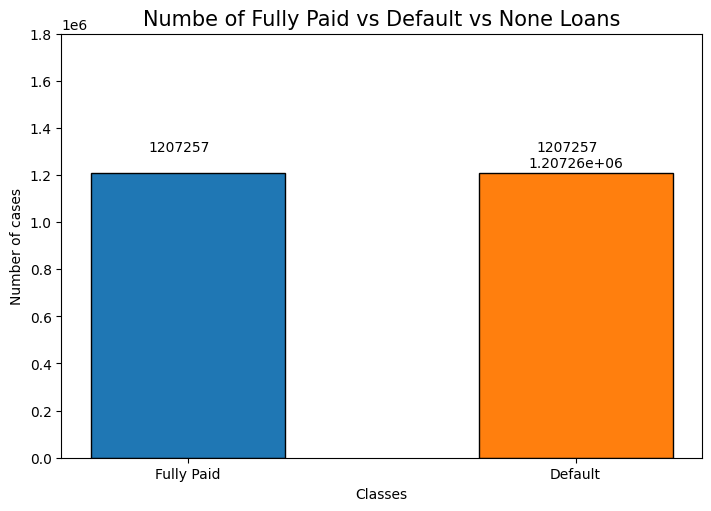

In [30]:
# Visualizing the encoded target

defalut_fully_paid = y_train_smotenc.value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.8,1300000,defalut_fully_paid[0])
ax.text(3.8,1300000,defalut_fully_paid[1])

fig.show()

In [31]:
# data under 6:2:2 train,val,test set

X_train, X_val, y_train, y_val = train_test_split(X_train_smotenc, y_train_smotenc, test_size=0.2, random_state=42, stratify=y_train_smotenc)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(augmentation_data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(augmentation_data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(augmentation_data):.1%})")

Train size: 1931611 samples (80.0%)
Validation size: 482903 samples (20.0%)
Test size: 266107 samples (11.0%)


In [32]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
1044693   0.871795     0.871795         0.872530   0.0  0.174523     0.653764   
1060167   0.153846     0.153846         0.158700   0.0  0.240358     0.131710   
2335757   0.358974     0.358974         0.362054   0.0  0.365777     0.293218   
2015114   0.335423     0.335423         0.339235   1.0  0.690352     0.236541   
1332635   0.230769     0.230769         0.235182   0.0  0.084534     0.178489   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
1044693  0.166667   0.205882             0.2    0.002587  ...        1.000000   
1060167  0.166667   0.264706             0.8    0.001248  ...        1.000000   
2335757  0.333333   0.411765             1.0    0.001425  ...        0.993494   
2015114  0.666667   0.500000             1.0    0.001985  ...        1.000000   
1332635  0.000000   0.088235             0.8    0.002154  ...        0.900000   

   

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=300,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.68973	validation_1-logloss:0.69300
[1]	validation_0-logloss:0.68624	validation_1-logloss:0.69273
[2]	validation_0-logloss:0.68284	validation_1-logloss:0.69233
[3]	validation_0-logloss:0.67943	validation_1-logloss:0.69196
[4]	validation_0-logloss:0.67601	validation_1-logloss:0.69176
[5]	validation_0-logloss:0.67267	validation_1-logloss:0.69144
[6]	validation_0-logloss:0.66934	validation_1-logloss:0.69128
[7]	validation_0-logloss:0.66603	validation_1-logloss:0.69102
[8]	validation_0-logloss:0.66278	validation_1-logloss:0.69076
[9]	validation_0-logloss:0.66073	validation_1-logloss:0.69040
[10]	validation_0-logloss:0.65757	validation_1-logloss:0.69044
[11]	validation_0-logloss:0.65442	validation_1-logloss:0.69049
[12]	validation_0-logloss:0.65125	validation_1-logloss:0.69030
[13]	validation_0-logloss:0.64813	validation_1-logloss:0.69013
[14]	validation_0-logloss:0.64505	validation_1-logloss:0.69024
[15]	validation_0-logloss:0.64203	validation_1-logloss:0.69012
[1

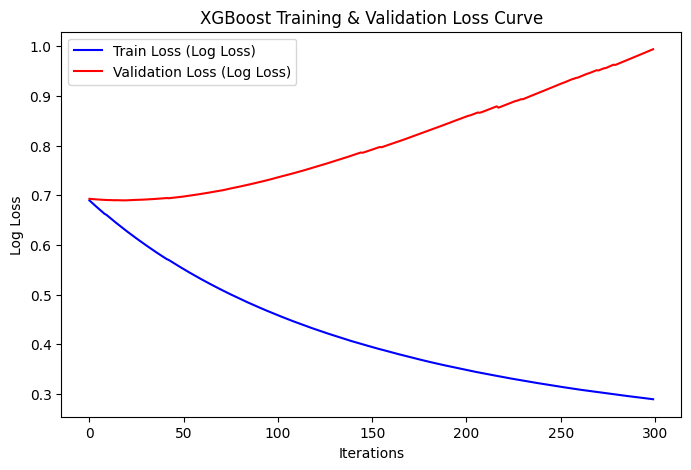

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    208044
           1       0.98      0.23      0.37     58063

    accuracy                           0.83    266107
   macro avg       0.90      0.61      0.64    266107
weighted avg       0.86      0.83      0.79    266107



In [34]:
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

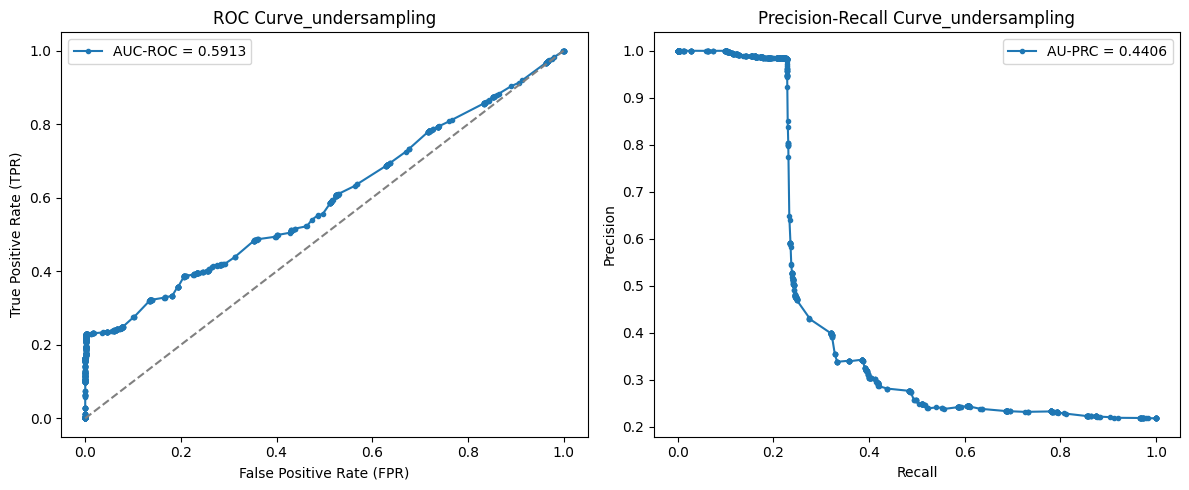

In [35]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

<Figure size 1000x800 with 0 Axes>

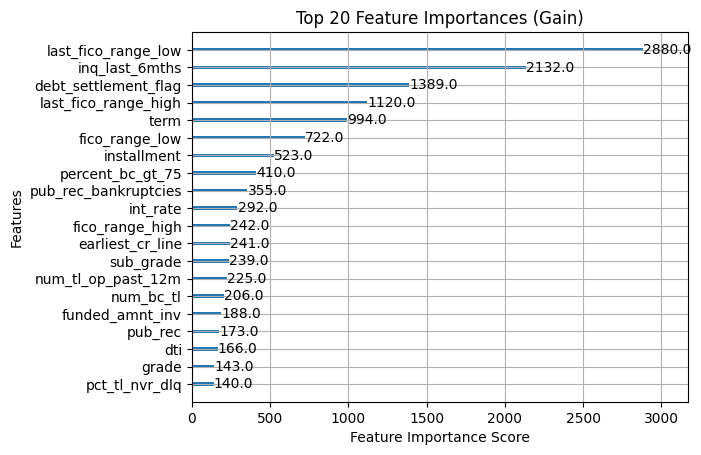

In [36]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()

## Undersampling Modeling

In [37]:
## Load before 2017 data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_train_before_2017_with_fico.csv"
data = pd.read_csv(data_path, low_memory=False)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

data = data.drop(columns=ambiguous_features)

In [38]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_test_after_2017_with_fico.csv"
test_data = pd.read_csv(test_data_path)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

test_data = test_data.drop(columns=ambiguous_features)

print(f"Test dataset the number of columns : {len(test_data.columns)}")

Test dataset the number of columns : 66


In [39]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [40]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

# 🔹 Test 데이터 Encoding 적용
X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

# ✅ Train에서 학습한 LabelEncoder로 변환 (fit_transform() ❌ → transform() ✅)
for col in X_test.select_dtypes(include=['object']).columns:
    if col in label_encoders:  # Train에서 학습한 LabelEncoder가 존재하는 경우
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# ✅ y_test도 Train에서 학습한 LabelEncoder 적용
y_test['loan_status'] = le_y.transform(y_test['loan_status'].astype(str))

# ✅ 변환된 데이터 확인
print("Encoded X_test sample:\n", X_test.head())
print("Encoded y_test sample:\n", y_test.head())

Encoded data_x sample:
    loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0    12000.0      12000.0          12000.0     0     10.99       392.81   
1     4800.0       4800.0           4800.0     0     10.99       157.13   
2    27050.0      27050.0          27050.0     0     10.99       885.46   
3    12000.0      12000.0          12000.0     0      7.62       373.94   
4    14000.0      14000.0          14000.0     0     12.85       470.71   

   grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
0      1          6               5     60000.0  ...           100.0   
1      1          6               1     39600.0  ...           100.0   
2      1          6               4     55000.0  ...           100.0   
3      0          2               1     96500.0  ...           100.0   
4      1          8               5     88000.0  ...            78.6   

   percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  \
0               0.0

In [41]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", data_y.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(data_x, data_y)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              1207257
1               287765
Name: count, dtype: int64
Original data size: 1495022 samples
Undersampled data size: 575530 samples

Undersampling imbalance check
loan_status
0    287765
1    287765
Name: count, dtype: int64


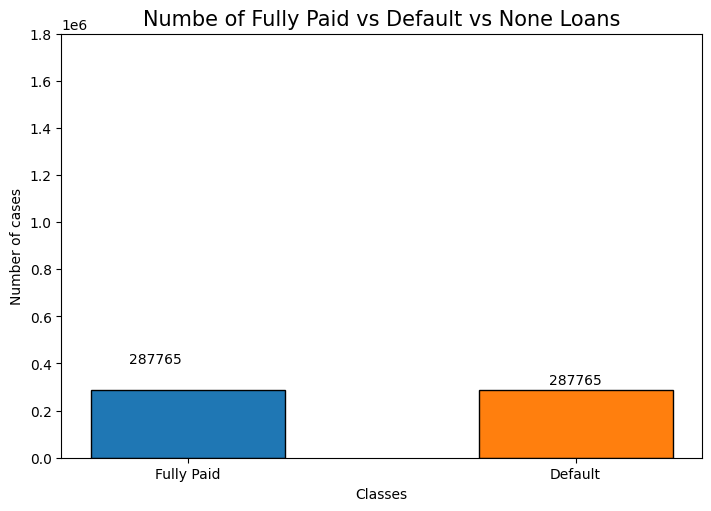

In [42]:
# Visualizing the encoded target

defalut_fully_paid = data_under['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.7,400000,defalut_fully_paid[0])
# ax.text(5.6,1150000,none_)

fig.show()

In [43]:
data_x = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
data_y = data_under[['loan_status']]  # Target (타겟 변수)

In [44]:
# data under 6:2:2 train,val,test set

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_under):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data_under):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_under):.1%})")

Train size: 460424 samples (80.0%)
Validation size: 115106 samples (20.0%)
Test size: 266107 samples (46.2%)


In [45]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
819346    0.205128     0.205128         0.207161   0.0  0.181924     0.162430   
1071330   0.512821     0.512821         0.514066   0.0  0.239579     0.398605   
20448     0.307692     0.307692         0.309463   0.0  0.325282     0.251685   
497800    0.118590     0.118590         0.120844   0.0  0.220880     0.099988   
734304    0.615385     0.615385         0.616368   0.0  0.100117     0.451473   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
819346   0.166667   0.205882             1.0    0.014623  ...           0.846   
1071330  0.166667   0.264706             0.2    0.022980  ...           0.941   
20448    0.166667   0.264706             0.2    0.004699  ...           0.921   
497800   0.166667   0.176471             1.0    0.005221  ...           0.857   
734304   0.000000   0.117647             1.0    0.009004  ...           1.000   

   

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=300,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.69005	validation_1-logloss:0.69267
[1]	validation_0-logloss:0.68678	validation_1-logloss:0.69198
[2]	validation_0-logloss:0.68353	validation_1-logloss:0.69127
[3]	validation_0-logloss:0.68032	validation_1-logloss:0.69059
[4]	validation_0-logloss:0.67716	validation_1-logloss:0.68994
[5]	validation_0-logloss:0.67402	validation_1-logloss:0.68886
[6]	validation_0-logloss:0.67091	validation_1-logloss:0.68825
[7]	validation_0-logloss:0.66783	validation_1-logloss:0.68767
[8]	validation_0-logloss:0.66478	validation_1-logloss:0.68711
[9]	validation_0-logloss:0.66388	validation_1-logloss:0.68648
[10]	validation_0-logloss:0.66105	validation_1-logloss:0.68662
[11]	validation_0-logloss:0.65823	validation_1-logloss:0.68680
[12]	validation_0-logloss:0.65528	validation_1-logloss:0.68630
[13]	validation_0-logloss:0.65234	validation_1-logloss:0.68582
[14]	validation_0-logloss:0.64960	validation_1-logloss:0.68603
[15]	validation_0-logloss:0.64674	validation_1-logloss:0.68558
[1

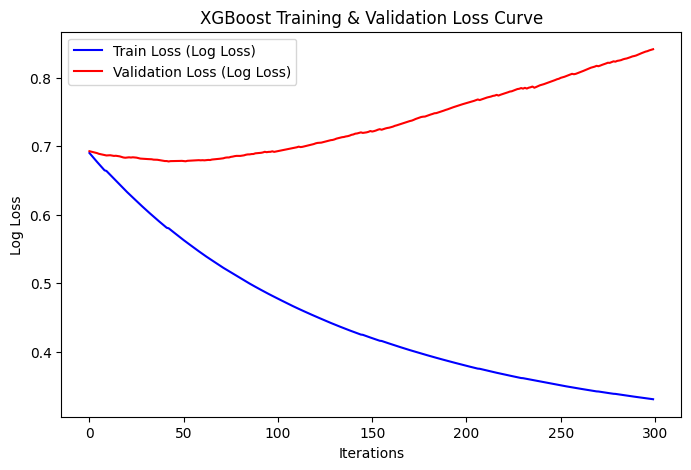

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    208044
           1       1.00      0.10      0.18     58063

    accuracy                           0.80    266107
   macro avg       0.90      0.55      0.53    266107
weighted avg       0.84      0.80      0.73    266107



In [47]:
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

'''threshold = 0.3
y_pred_adjusted = (y_prob>threshold).astype(int)'''

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

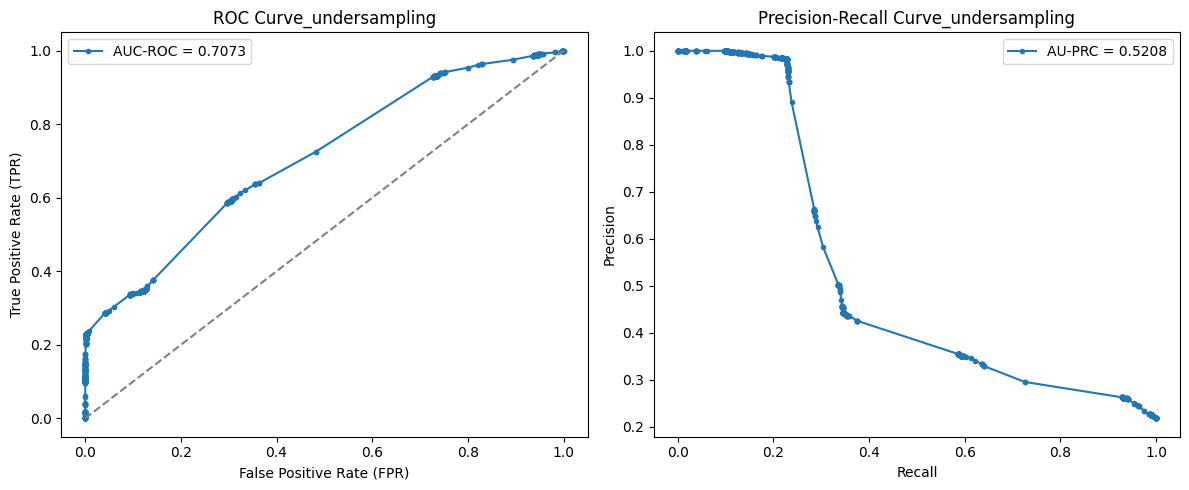

In [48]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

<Figure size 1000x800 with 0 Axes>

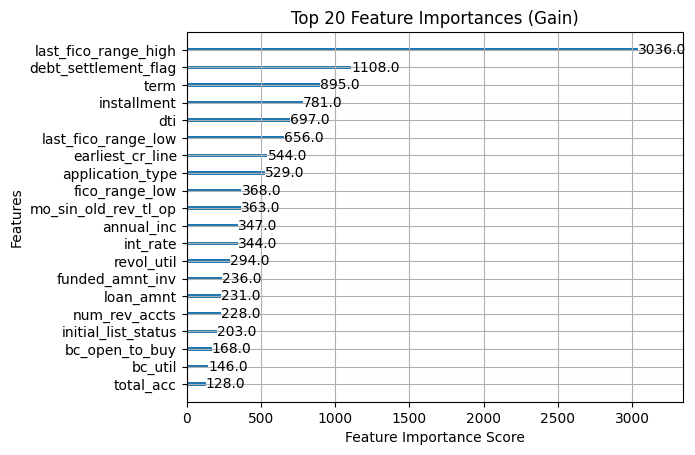

In [49]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()

## Tablegan Modeling

In [ ]:
## Load before 2017 data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_train_before_2017.csv"
data = pd.read_csv(data_path, low_memory=False)

In [ ]:
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/train/train_custom_fake.csv"
fake = pd.read_csv(fake_path)

fake['loan_status'] = 1

In [ ]:
from sklearn.utils import shuffle

train_total = pd.concat([data,fake])
train_total = shuffle(train_total, random_state=42)

In [ ]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_test_after_2017.csv"
test_data = pd.read_csv(test_data_path)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

train_total = train_total.drop(columns=ambiguous_features)
test_data = test_data.drop(columns=ambiguous_features)

print(f"Train dataset the number of columns : {len(train_total.columns)}\nTest dataset the number of columns : {len(test_data.columns)}")

In [ ]:
# Visualizing the encoded target

defalut_fully_paid = train_total['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Number of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
#ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [ ]:
data_x = train_total.drop(columns='loan_status')
data_y = train_total[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [ ]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

# 🔹 Test 데이터 Encoding 적용
X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

# ✅ Train에서 학습한 LabelEncoder로 변환 (fit_transform() ❌ → transform() ✅)
for col in X_test.select_dtypes(include=['object']).columns:
    if col in label_encoders:  # Train에서 학습한 LabelEncoder가 존재하는 경우
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# ✅ y_test도 Train에서 학습한 LabelEncoder 적용
y_test['loan_status'] = le_y.transform(y_test['loan_status'].astype(str))

# ✅ 변환된 데이터 확인
print("Encoded X_test sample:\n", X_test.head())
print("Encoded y_test sample:\n", y_test.head())

In [ ]:
# data under 6:2:2 train,val,test set

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(train_total):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(train_total):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(train_total):.1%})")

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

"""pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
scale_pos_weight = neg / pos  # 클래스 비율 계산"""

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=300,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

In [ ]:
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

'''threshold = 0.3
y_pred_adjusted = (y_prob>threshold).astype(int)'''

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [ ]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

In [ ]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()